<a href="https://colab.research.google.com/github/jarrodmhicks/neuromatch_similarity/blob/main/notebooks/first_pass_similarity_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [ ]:
# @title Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# @title Define main distance model class

class DistanceModel(nn.Module):
  def __init__(self, transform, distance, device=device):
    super(DistanceModel, self).__init__()
    self.transform = transform
    self.distance = distance

  def forward(self, features): # batch dim by 3 by n features
    transformed_features = self.transform(features) # batch dim by 3 by k features
    distances = torch.hstack((torch.unsqueeze(self.distance(transformed_features[:, 1, :], transformed_features[:, 2, :]), 1),
                              torch.unsqueeze(self.distance(transformed_features[:, 0, :], transformed_features[:, 2, :]), 1),
                              torch.unsqueeze(self.distance(transformed_features[:, 0, :], transformed_features[:, 1, :]), 1)))
    return -distances # batch dim by 3

In [ ]:
# @title Define transforms

# TODO: incorporate seeding for reproducibility

class IdentityTransform(nn.Module):
  def __init__(self):
    super(IdentityTransform, self).__init__()

  def forward(self, features):
    return features # return features

class DiagonalLinearTransform(nn.Module):
  def __init__(self, n_features):
    super(DiagonalLinearTransform, self).__init__()
    self.diagonal = nn.Parameter(torch.randn(n_features)) # TODO: try initializing with different variances

  def forward(self, features):
    return features * self.diagonal # equivalent to features @ torch.diag(self.diagonal)

class FullLinearTransform(nn.Module):
  def __init__(self, n_features):
    super(FullLinearTransform, self).__init__()
    self.transformation_matrix = nn.Parameter(torch.randn(n_features, n_features))

  def forward(self, features):
    return features @ self.transformation_matrix

# TODO: neural network transforms can go here

In [ ]:
# @title Define distances

class CosineDistance(nn.Module):
  def __init__(self):
    super(CosineDistance, self).__init__()
    self.cos_sim = nn.CosineSimilarity(dim=1)

  def forward(self, input1, input2):
    return 1 - self.cos_sim(input1, input2)

# TODO: other distance metrics can go here

In [ ]:
# @title Define utilities

# TODO: update how train/test split happens to exclude a subset of images rather than trials...

class SimilarityDataset(Dataset):
  def __init__(self, image_indices, human_decisions, hold_out=0.1):
    self.total_samples = len(human_decisions)
    self.n_train = int(round(self.total_samples * (1 - hold_out)))
    self.n_test = int(self.total_samples - self.n_train)
    self.decisions = human_decisions
    self.triplets = image_indices

  def __len__(self):
    return self.total_samples

  def __getitem__(self, index):
    triplet = self.triplets[index,:]
    decision = self.decisions[index]
    return triplet, decision

def train_model(features, model, optimizer, loss_function, train_loader, device=device, summary=True):
  n_steps = len(train_loader)
  for i, (triplets, targets) in enumerate(train_loader):
    # send data to device
    inputs = features[triplets,:]

    # data should already be on device!
    # inputs = inputs.to(device)
    # targets = targets.to(device)

    # forward pass
    outputs = model(inputs)
    loss = loss_function(outputs, targets)

    # backward and optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print summary on last step of epoch
    if ((i+1) == n_steps) & summary:
      print(f'\tStep [{i+1}/{n_steps}], Loss: {loss.item():.6f}')

  return loss.item()

def model_performance(outputs, targets):
  model_decisions = torch.argmax(outputs, dim=1)
  performance = torch.sum(model_decisions == targets) / len(targets)
  return performance.item()


# TODO: write saving utility
'''
should save final model, performance, and specifications (e.g,. which network
activations were used, which transform, which distance, what seed)
'''

In [ ]:
# @title Read in human data

human_data_link = 'https://osf.io/download/h2smy/'
df = pd.read_csv(human_data_link, delimiter='\t')
image_indices = torch.tensor(np.array(df[['image1', 'image2', 'image3']]), device=device)-1
human_decisions = torch.squeeze(torch.tensor(np.array(df[['choice']]), device=device)-1)

In [ ]:
# @title Read in network activations

# mount google drive
mounted_dir = '/content/drive'
drive.mount(mounted_dir, force_remount=True)

# specify model and layer
featureModel = 'alexnet'
featureModelLayer = 'classifier.5'

featureModelDir = f'features_{featureModel}_{featureModelLayer}'
features_file = os.path.join('neuromatch/network_features', featureModelDir, 'features.npy') # point to wherever this in your drive
full_feature_path = os.path.join(mounted_dir, 'MyDrive', features_file)

network_activations = torch.from_numpy(np.load(full_feature_path)).to(device)

Mounted at /content/drive


In [ ]:
# @title Setup entire model

# params
n_trials = 100000 # for testing
hold_out = 0.1
num_epochs = 30
batch_size = 10000
learning_rate = 0.01
summary_every = 10

# initialize dataset
dataset = SimilarityDataset(image_indices[:n_trials,:], human_decisions[:n_trials], hold_out=hold_out)
train_dataset, test_dataset = random_split(dataset, [dataset.n_train, dataset.n_test])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True)

# intialize vanilla model
identity_transform = IdentityTransform()
distance = CosineDistance() # initialize distance
original_model = DistanceModel(identity_transform, distance)
original_model.to(device)

# initialize model components
transform = DiagonalLinearTransform(network_activations.shape[1]) # initialize transform
model = DistanceModel(transform, distance) # initialize distance model
model.to(device)

# intialize loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# @title Train model

train_losses = []
for epoch in range(num_epochs):
  if (epoch+1) % summary_every == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    summary = True
  else:
    summary = False
  train_loss = train_model(network_activations, model, optimizer, loss_function, train_loader, device=device, summary=summary)
  train_losses.append(train_loss)

Epoch [10/30]
	Step [9/9], Loss: 1.075253
Epoch [20/30]
	Step [9/9], Loss: 1.068998
Epoch [30/30]
	Step [9/9], Loss: 1.057930


In [ ]:
# @title Evaluate model performance on test set

(test_triplets, test_targets) = next(iter(test_loader))
with torch.no_grad():
  test_inputs = network_activations[test_triplets,:]
  test_inputs = test_inputs.to(device)
  test_targets = test_targets.to(device)
  test_outputs = model(test_inputs)
  test_outputs_original = original_model(test_inputs)
final_performance = model_performance(test_outputs, test_targets)
final_performance_original = model_performance(test_outputs_original, test_targets)

zero-shot performance: 0.45729997754096985
transformed performance: 0.4860000014305115


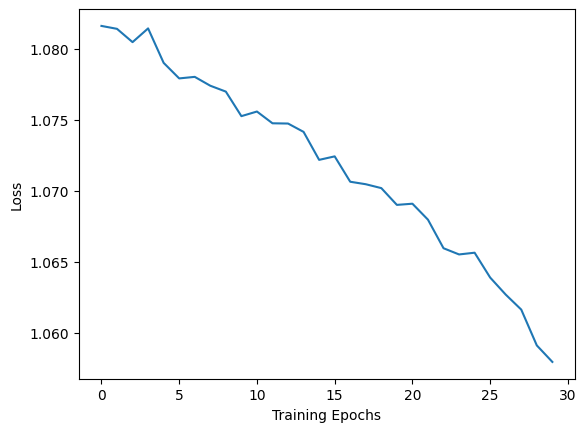

In [ ]:
# @title Results summary

print(f'zero-shot performance: {final_performance_original}')
print(f'transformed performance: {final_performance}')

plt.plot(train_losses)
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.show()